# OCHA trigger thresholds

This notebook is for determining trigger thresholds for 
the OCHA Philippines trigger

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import genextreme as gev
from scipy.interpolate import interp1d

In [2]:
# The regions of interest and their pcodes
ROI = {
    "5": "PH050000000", 
    "8": "PH080000000", 
    "13": "PH160000000", 
}

## Reading in the data

In [3]:
# Read in the typhoon info
filename = "../../IBF-Typhoon-model/data/loos_table_ibtrcs.csv"
df_typhoon = pd.read_csv(filename, index_col=0)
df_typhoon["year"] = df_typhoon["typhoon"].apply(lambda x: int(x[:4]))
# Drop 2022 because it will mess up the RP
df_typhoon = df_typhoon.loc[df_typhoon["year"] != 2022]
df_typhoon

,Mun_Code,typhoon,No_Totally_DMG_BLD,year
0,PH175317000,1990129N05138,0,1990
1,PH175323000,1990129N05138,8,1990
2,PH012803000,1990163N08133,67,1990
3,PH012805000,1990163N08133,6,1990
4,PH012814000,1990163N08133,1,1990
...,...,...,...,...
106517,PH184621000,2021347N05142,1440,2021
106518,PH184622000,2021347N05142,901,2021
106519,PH184623000,2021347N05142,3376,2021
106520,PH184624000,2021347N05142,2450,2021


In [4]:
# Check the number of years is complete
typhoon_year_list = df_typhoon.year.unique()
nyears = len(typhoon_year_list)
typhoon_year_list

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [5]:
# Read in the geo info
filename_geo = "../../IBF-Typhoon-model/data/gis_data/phl_admin3_simpl.geojson"
gdf = gpd.read_file(filename_geo)
gdf

,adm3_en,adm3_pcode,adm2_pcode,adm1_pcode,glat,glon,geometry
0,Adams,PH012801000,PH012800000,PH010000000,18.453,120.919,"MULTIPOLYGON (((120.94626 18.51158, 120.96915 ..."
1,Bacarra,PH012802000,PH012800000,PH010000000,18.267,120.613,"MULTIPOLYGON (((120.59081 18.29526, 120.59192 ..."
2,Badoc,PH012803000,PH012800000,PH010000000,17.906,120.509,"MULTIPOLYGON (((120.47783 17.97744, 120.47803 ..."
3,Bangui,PH012804000,PH012800000,PH010000000,18.490,120.750,"MULTIPOLYGON (((120.79393 18.53475, 120.79537 ..."
4,City of Batac,PH012805000,PH012800000,PH010000000,18.038,120.584,"MULTIPOLYGON (((120.56070 18.12259, 120.56088 ..."
...,...,...,...,...,...,...,...
1642,Tayasan,PH184622000,PH184600000,PH180000000,9.944,123.075,"MULTIPOLYGON (((123.16419 9.95278, 123.16998 9..."
1643,Valencia,PH184623000,PH184600000,PH180000000,9.291,123.161,"MULTIPOLYGON (((123.20764 9.32295, 123.21151 9..."
1644,Vallehermoso,PH184624000,PH184600000,PH180000000,10.343,123.293,"MULTIPOLYGON (((123.33592 10.38248, 123.33565 ..."
1645,Zamboanguita,PH184625000,PH184600000,PH180000000,9.162,123.162,"MULTIPOLYGON (((123.17078 9.22988, 123.18679 9..."


## Make a combined data frame with damage totals

In [6]:
# Merge them
df_comb = (pd.merge(df_typhoon, gdf[["adm3_pcode", "adm1_pcode"]], 
              left_on="Mun_Code", right_on="adm3_pcode", how="left")
      .drop(columns=["adm3_pcode"])
     )
df_comb

,Mun_Code,typhoon,No_Totally_DMG_BLD,year,adm1_pcode
0,PH175317000,1990129N05138,0,1990,PH170000000
1,PH175323000,1990129N05138,8,1990,PH170000000
2,PH012803000,1990163N08133,67,1990,PH010000000
3,PH012805000,1990163N08133,6,1990,PH010000000
4,PH012814000,1990163N08133,1,1990,PH010000000
...,...,...,...,...,...
106517,PH184621000,2021347N05142,1440,2021,PH180000000
106518,PH184622000,2021347N05142,901,2021,PH180000000
106519,PH184623000,2021347N05142,3376,2021,PH180000000
106520,PH184624000,2021347N05142,2450,2021,PH180000000


In [7]:
# Group by admin1 and typhoon, and sum, then take max of each year
df_max = (df_comb.groupby(['adm1_pcode', 'typhoon'])
      .agg({'No_Totally_DMG_BLD': sum,'year': 'first'})
     .groupby(['adm1_pcode', 'year']).max()
     .rename(columns={'No_Totally_DMG_BLD': 'max_damage_event'})
     .reset_index()
             )
df_max

,adm1_pcode,year,max_damage_event
0,PH010000000,1990,2161
1,PH010000000,1991,4121
2,PH010000000,1992,5996
3,PH010000000,1993,7992
4,PH010000000,1994,1769
...,...,...,...
496,PH180000000,2017,3952
497,PH180000000,2018,542
498,PH180000000,2019,3381
499,PH180000000,2020,425


In [8]:
# Now do the same but taking the ROI as a whole
df_max_roi = (df_comb.loc[df_comb['adm1_pcode'].isin(ROI.values())]
              .groupby('typhoon')
              .agg({'No_Totally_DMG_BLD': sum,'year': 'first'})
              .groupby(['year']).max()
              .rename(columns={'No_Totally_DMG_BLD': 'max_damage_event'})
              .reset_index()
             )

df_max_roi



,year,max_damage_event
0,1990,76077
1,1991,22317
2,1992,6604
3,1993,93722
4,1994,48578
5,1995,77547
6,1996,12366
7,1997,5789
8,1998,74407
9,1999,10108


## Get the return periods

In [9]:
def get_rp_analytical(
    df_rp: pd.DataFrame,
    rp_var: str,
    show_plots: bool = False,
    plot_title: str = "",
    extend_factor: int = 1,
):
    """
    :param df_rp: DataFrame where the index is the year, and the rp_var
    column contains the maximum value per year
    :param rp_var: The column with the quantity to be evaluated
    :param show_plots: Show the histogram with GEV distribution overlaid
    :param plot_title: The title of the plot
    :param extend_factor: Extend the interpolation range in case you want to
    calculate a relatively high return period
    :return: Interpolated function that gives the quantity for a
    given return period
    """
    df_rp = df_rp.sort_values(by=rp_var, ascending=False)
    rp_var_values = df_rp[rp_var]
    shape, loc, scale = gev.fit(
        rp_var_values,
        loc=rp_var_values.median(),
        scale=rp_var_values.median() / 2,
    )
    x = np.linspace(
        rp_var_values.min(),
        rp_var_values.max() * extend_factor,
        100 * extend_factor,
    )
    if show_plots:
        fig, ax = plt.subplots()
        ax.hist(rp_var_values, density=True, bins=20)
        ax.plot(x, gev.pdf(x, shape, loc, scale))
        ax.set_title(plot_title)
        plt.show()
    y = gev.cdf(x, shape, loc, scale)
    y = 1 / (1 - y)
    return interp1d(y, x)


def get_rp_empirical(df_rp: pd.DataFrame, rp_var: str):
    """
    :param df_rp: DataFrame where the index is the year, and the rp_var
    column contains the maximum value per year
    :param rp_var: The column
    with the quantity to be evaluated
    :return: Interpolated function
    that gives the quantity for a give return period
    """
    df_rp = df_rp.sort_values(by=rp_var, ascending=False)
    n = len(df_rp)
    df_rp["rank"] = np.arange(n) + 1
    df_rp["exceedance_probability"] = df_rp["rank"] / (n + 1)
    df_rp["rp"] = 1 / df_rp["exceedance_probability"]
    return interp1d(df_rp["rp"], df_rp[rp_var])



def get_rp_df(
    df: pd.DataFrame,
    rp_var: str,
    years: list = None,
    method: str = "analytical",
    show_plots: bool = False,
    extend_factor: int = 1,
    round_rp: bool = True,
) -> pd.DataFrame:
    """
    Function to get the return periods, either empirically or
    analytically See the `glofas/utils.py` to do this with a xarray
    dataset instead of a dataframe
    :param df: Dataframe with data to compute rp on
    :param rp_var: column name to compute return period on
    :param years: Return period years to compute
    :param method: Either "analytical" or "empirical"
    :param show_plots: If method is analytical, can show the histogram and GEV
    distribution overlaid
    :param extend_factor: If method is analytical, can extend the interpolation
    range to reach higher return periods
    :param round_rp: if True, round the rp values, else return original values
    :return: Dataframe with return period years as index and stations as
    columns
    """
    if years is None:
        years = [1.5, 2, 3, 5]
    df_rps = pd.DataFrame(columns=["rp"], index=years)
    if method == "analytical":
        f_rp = get_rp_analytical(
            df_rp=df,
            rp_var=rp_var,
            show_plots=show_plots,
            extend_factor=extend_factor,
        )
    elif method == "empirical":
        f_rp = get_rp_empirical(
            df_rp=df,
            rp_var=rp_var,
        )
    else:
        print(f"{method} is not a valid keyword for method")
        return None
    df_rps["rp"] = f_rp(years)
    if round_rp:
        df_rps["rp"] = np.round(df_rps["rp"])
    return df_rps


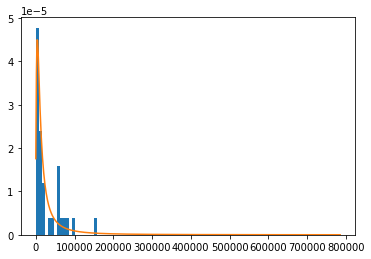

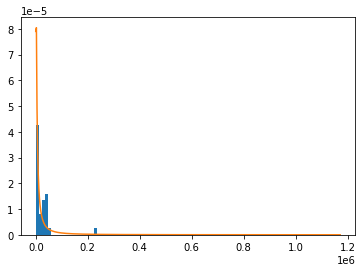

/home/turnerm/sync/Typhoon-Impact-based-forecasting-model/venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)


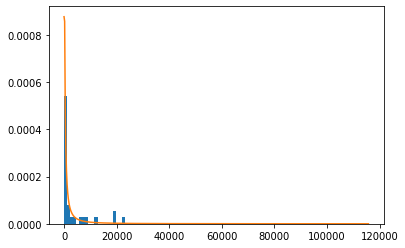

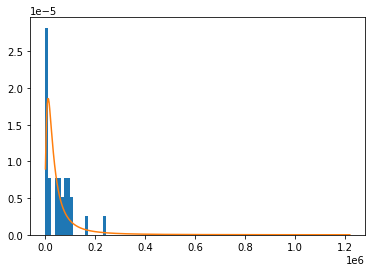

,rp,max_damage,region
0,3,24135.0,5
1,4,33645.0,5
2,5,42752.0,5
3,10,84980.0,5
4,15,124142.0,5
5,20,161500.0,5
6,25,197587.0,5
7,3,15989.0,8
8,4,25712.0,8
9,5,36405.0,8


In [10]:
years = [3, 4, 5, 10, 15, 20, 25]
df_rp = pd.DataFrame()
method = "analytical"
#method = "empirical"

# Only do for regions 5, 8, and 13
for region_key, region_value in ROI.items():
    df = df_max.loc[df_max["adm1_pcode"] == region_value]
    if len(region_value) > 1:
         df = df.groupby("year").sum().reset_index()
    # Check to make sure each year is covered, if not needs to be filled with 0
    if len(df) < nyears:
        missing_years = set(typhoon_year_list) - set(df.year)
        print(f"Warning: need to fill in missing years {missing_years} for {region_key}")
        for year in missing_years:
            df = df.append({"year": year,
                       "max_damage_event": 0}, ignore_index=True)
    df = df.set_index(df.year)
    df_rp_tmp = (get_rp_df(df, "max_damage_event", years=years, extend_factor=5,
                          method=method, show_plots=True)
                 .reset_index()
                 .rename(columns={"rp": "max_damage", "index": "rp"})
                )
    df_rp_tmp["region"] = region_key
    df_rp = pd.concat([df_rp, df_rp_tmp], ignore_index=True)
    
# Then for all 3 regions
df = df_max_roi.copy()
df = df.set_index(df.year)
df_rp_tmp = (get_rp_df(df, "max_damage_event", years=years, extend_factor=5,
                      method=method, show_plots=True)
             .reset_index()
             .rename(columns={"rp": "max_damage", "index": "rp"})
            )
df_rp_tmp["region"] = "5,8,13"
df_rp = pd.concat([df_rp, df_rp_tmp], ignore_index=True)


df_rp


In [11]:
df_rp.to_csv("rp_damage_per_region.csv", index=False)